<a href="https://colab.research.google.com/github/KFurudate/Midoribon/blob/main/chap10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第10章 階層ベイズモデル - GLMMのベイズモデル化ー


参考にさせていただきました。ありがとうございます！
https://github.com/ohke/introduction_to_statistical_modeling_for_data_analysis/blob/master/chapter10.ipynb


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.special import comb
from scipy import stats
%matplotlib inline

In [3]:
data_dir = "/content/drive/My Drive/Midoribon/input/"
data =  pd.read_csv(os.path.join(data_dir, 'chap10a_data.csv'))

In [4]:
print(len(data))
data

100


,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1
...,...,...
95,96,1
96,97,0
97,98,4
98,99,7


In [5]:
data.describe()

,id,y
count,100.000000,100.000000
mean,50.500000,4.030000
std,29.011492,3.150934
min,1.000000,0.000000
25%,25.750000,1.000000
50%,50.500000,4.000000
75%,75.250000,7.000000
max,100.000000,8.000000


In [6]:
data2 = data.groupby(by="y").count().reset_index()
data2

,y,id
0,0,19
1,1,15
2,2,10
3,3,3
4,4,6
5,5,4
6,6,6
7,7,17
8,8,20


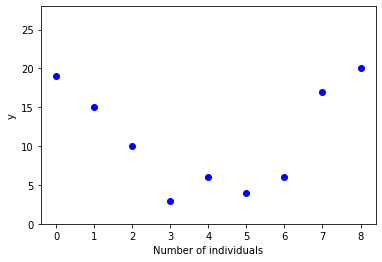

In [7]:
plt.plot(data2.id, "bo")
plt.xlabel('Number of individuals')
plt.ylabel('y')
plt.ylim(0, 28)
plt.show()

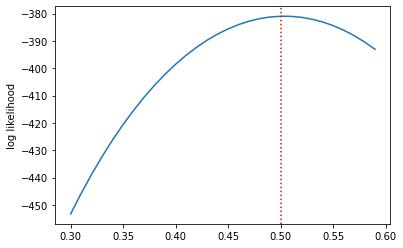

生存率 q: 0.5　で対数尤度が最大（最尤推定値）


In [8]:
Q = np.arange(0.3, 0.6, 0.01)
logL = []
for q in Q:
  logL.append(sum([stats.binom.logpmf(i, 8, q) for i in data.y]))
logL = np.array(logL)
plt.plot(Q, logL)
plt.axvline(Q[logL.argmax()], color='red', linestyle='dotted')

plt.ylabel("log likelihood")
plt.show()
print(f"生存率 q: {round(Q[logL.argmax()], 2)}　で対数尤度が最大（最尤推定値）")

In [9]:
#生存確率
p = 0.5
p

0.5

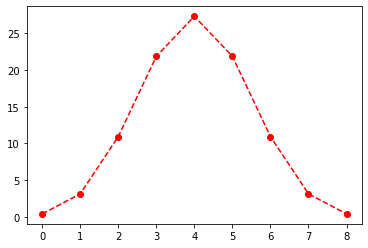

In [10]:
#生存確率0.5の二項分布
x = range(9)
n = data2.id.sum()
binomial = stats.binom.pmf(x, 8, p)*n
plt.plot(x, binomial, "ro--")
plt.show()

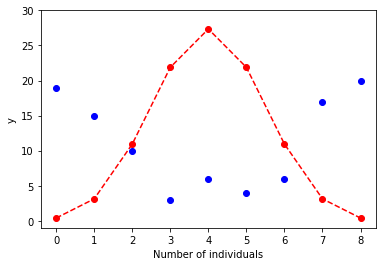

In [11]:
x = range(9)
n = data2.id.sum()
binomial = stats.binom.pmf(x, 8, p)*n
plt.plot(x, binomial, "ro--")

plt.plot(data2.id, "bo")

plt.xlabel('Number of individuals')
plt.ylabel('y')
plt.ylim(-1, 30)
plt.show()

In [12]:
# 確率0.5でN＝８の二項分布の分散は、8 * 0.5*(1-0.5)=2.0
# 期待される分散2より、実際の分散9.93であり、過分散となっている

print(f'平均: {data.y.mean()}')
print(f'分散: {round(data.y.var(), 2)}')

平均: 4.03
分散: 9.93


### GLMMの階層ベイズモデル化

#### 統計モデルの設計
7章と同じく、リンク関数と線形予測子は　$logit(q_i) = \log \frac {q_i}{1-q_i} = \beta + r_i　$ とする。

ここで、切片$\beta$は全個体に共通するパラメーターであり、$r_i$は個体差をあらわす。平均ゼロで標準偏差$s$の正規分布に従うと仮定する。

データが得られる確率 $　p({\bf Y} | \beta, \{r_i\}) $ は全100個体の二項分布の積なので、以下となる。

$$
p({\bf Y} | \beta, \{r_i\}) = \prod_i \binom {8}{y_i} q_i^{y_i} (1-q_i)^{8-y_i}
$$

推定したい事後分布は、$\propto　p({\bf Y} | \beta, \{r_i\}) \times$事前分布となる。




あとは事前分布を指定すれば統計モデルの設計は完了

#### 事前分布の設計
$\beta$の事前分布として、平均0、標準偏差100のひらべったい正規分布の無情報事前分布を指定する。$$
p(\beta) = \frac {1}{\sqrt {2\pi \times 100^2}}\exp \left(\frac {-\beta^2}{2\times100^2} \right)
$$

個体差$r_i$の事前分布は平均0、標準偏差$s$の正規分布と仮定する。
ここで、$s$は個体差を表す100個の$r_i$がどれくらいバラついてるかをあらわす。$$
p(r_i | s) = \frac {1}{\sqrt {2\pi s^2}}\exp \left(\frac {-{r_i}^2}{2 s^2} \right)
$$

第7章では、最尤推定によって、一つの$\hat s$を指定した。

ここでは、$s$を$p(s) = $(0から$10^4$までの連続一様分布)の無情報事前分布とする（正の値であればなんでも構わない）。

In [13]:
pip install pymc3==3.9.3

     |████████████████████████████████| 1.9MB 5.3MB/s 
     |████████████████████████████████| 1.5MB 18.9MB/s 
     |████████████████████████████████| 4.3MB 35.1MB/s 
     |████████████████████████████████| 737kB 45.2MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 296kB 45.7MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=38d60b0e67d10ef58adb61a254d3d16115c4259d04fb06430485920a406a4d52
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [14]:
import pymc3

In [15]:
with pymc3.Model() as model:
    # βの事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta = pymc3.Normal('beta', mu=0, sd=100)
    
    # 超パラメータsの(超)事前分布をU(0, 10**4)の連続一様分布で設定(無情報事前分布)
    s = pymc3.Uniform('s', lower=0, upper=10**4)
    
    # パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pymc3.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # ロジットリンク関数を設定し、二項分布で推定する
    y = pymc3.Binomial('y', n=8, p=pymc3.invlogit(beta + r), observed=data.y.values)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [r, s, beta]


Sampling 3 chains for 100 tune and 2_000 draw iterations (300 + 6_000 draws total) took 120 seconds.
The acceptance probability does not match the target. It is 0.9445005246181806, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9252162006675342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364263094807024, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 wi

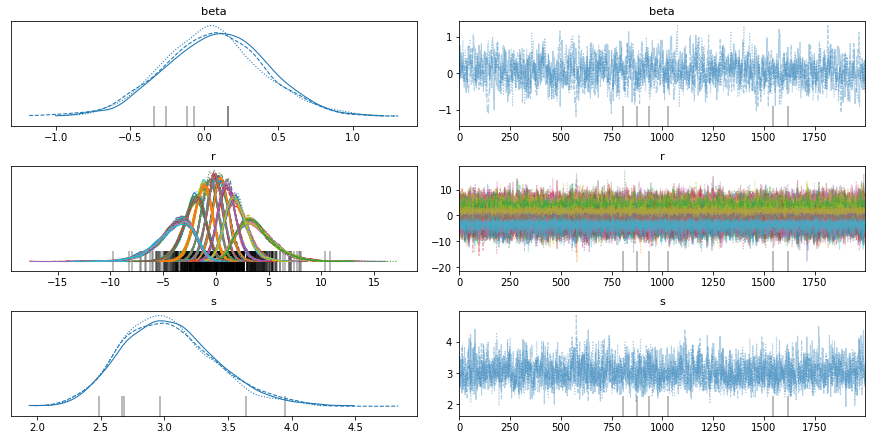

In [16]:
with model:
    step = pymc3.NUTS()
    trace = pymc3.sample(2000, step=step, tune=100, cores=3, random_seed=42)
    
_ = pymc3.traceplot(trace)

In [17]:
pymc3.summary(trace).loc[['beta', 's']]

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.069,0.342,-0.558,0.724,0.013,0.009,715.0,715.0,714.0,1679.0,1.0
s,3.035,0.370,2.359,3.745,0.009,0.007,1599.0,1580.0,1631.0,2791.0,1.0


### MCMCサンプルから事後分布を推定

In [18]:
from scipy.stats import binom, norm

# 事後分布p(β|Y), p(s|Y)を3つのサンプル列の平均値で求める
beta_averages = np.zeros(len(trace), dtype=np.float64)
s_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
    beta_averages += trace.get_values('beta', chains=i) / trace.nchains
    s_averages += trace.get_values('s', chains=i) / trace.nchains

# シグモイド関数
q = lambda beta, r: 1 / (1 + math.exp(-(beta + r)))

# 全サンプル・全個体の種子数yの生存確率を計算
probs = []

for (beta, s) in zip(beta_averages, s_averages):
    individuals_probs = []
    
    # 100個体を生成
    for r in norm.rvs(loc=0, scale=s, size=100):
        y_probs = []
        
        # 各個体の種子数(0〜8個)の生存確率を計算
        for y in range(9):
            y_probs.append(binom.pmf(y, 8, q(beta, r)))
            
        individuals_probs.append(y_probs)
        
    probs.append(individuals_probs)
    
probs = np.array(probs)

print(probs.shape) # (1500, 100, 9)

(2000, 100, 9)


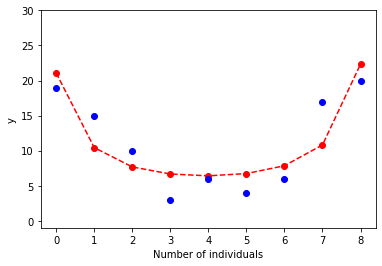

In [19]:
plt.plot(np.average(np.average(probs, axis=1), axis=0) * 100, 'ro--', label='predicted(avg)')
plt.plot(data2.id, "bo",  label='actually')

plt.xlabel('Number of individuals')
plt.ylabel('y')
plt.ylim(-1, 30)
plt.show()

###個体差＋場所差の階層ベイズモデル

In [20]:
data =  pd.read_csv(os.path.join(data_dir, 'chap10b_data.csv'))

In [23]:
data

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0
...,...,...,...,...
95,96,J,T,1
96,97,J,T,1
97,98,J,T,2
98,99,J,T,1


In [22]:
data.describe()

,id,y
count,100.000000,100.000000
mean,50.500000,5.520000
std,29.011492,7.375197
min,1.000000,0.000000
25%,25.750000,1.000000
50%,50.500000,3.000000
75%,75.250000,7.000000
max,100.000000,37.000000


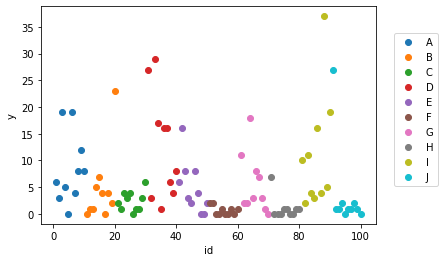

In [40]:
label = data["pot"].unique()
for l in label:
    plt.scatter(data[data.pot == l]["id"], data[data.pot == l]["y"], label=l)
    
plt.legend(bbox_to_anchor=(1.2, 0.9))
plt.xlabel('id')
plt.ylabel('y')
plt.show()

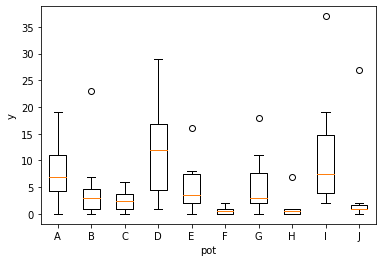

In [37]:
label = data["pot"].unique()
plt.boxplot([data[data.pot == i]["y"] for i in label], labels=label)
plt.xlabel('pot')
plt.ylabel('y')
plt.plot()
plt.show()

In [42]:
# T(施肥処理有り)の場合に1となる変数Fを追加
data['F'] = pd.get_dummies(data["f"])["T"]
# A〜Jを0〜9に対応付けた変数POTを追加
data['POT'] = data["pot"].apply(lambda p: ord(p) - ord('A'))

data

,id,pot,f,y,F,POT
0,1,A,C,6,0,0
1,2,A,C,3,0,0
2,3,A,C,19,0,0
3,4,A,C,5,0,0
4,5,A,C,0,0,0
...,...,...,...,...,...,...
95,96,J,T,1,1,9
96,97,J,T,1,1,9
97,98,J,T,2,1,9
98,99,J,T,1,1,9


In [48]:
with pymc3.Model() as model:
    # β1とβ2の事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta1 = pymc3.Normal('beta1', mu=0, sd=100)
    beta2 = pymc3.Normal('beta2', mu=0, sd=100)
    
    # sとspの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pymc3.Uniform('s', lower=0, upper=10000)
    sp = pymc3.Uniform('sp', lower=0, upper=10000)
    
    # 個体差パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pymc3.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # 場所差パラメータrpの事前分布をN(0, sp)の正規分布で設定(階層事前分布)
    rp = pymc3.Normal('rp', mu=0, sd=sp, shape=len(data.POT.unique()))
    
    # ログリンク関数を設定し、ポアソン分布で推定する
    y = pymc3.Poisson('y', mu=np.exp(beta1 + beta2 * data.F + r + rp[data.POT]), observed=data.y.values)


Sequential sampling (2 chains in 1 job)
HamiltonianMC: [rp, r, sp, s, beta2, beta1]


Sampling 2 chains for 100 tune and 2_000 draw iterations (200 + 4_000 draws total) took 68 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9340718503358234, but should be close to 0.65. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8869727975317308, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta1,1.386,0.520,0.398,2.404,0.017,0.012,988.0,963.0,1026.0,1143.0,1.0
beta2,-0.858,0.734,-2.202,0.518,0.020,0.016,1301.0,1084.0,1384.0,1255.0,1.0
s,1.019,0.116,0.804,1.232,0.003,0.002,1608.0,1608.0,1607.0,2381.0,1.0
sp,1.036,0.390,0.445,1.696,0.019,0.014,415.0,415.0,382.0,803.0,1.0


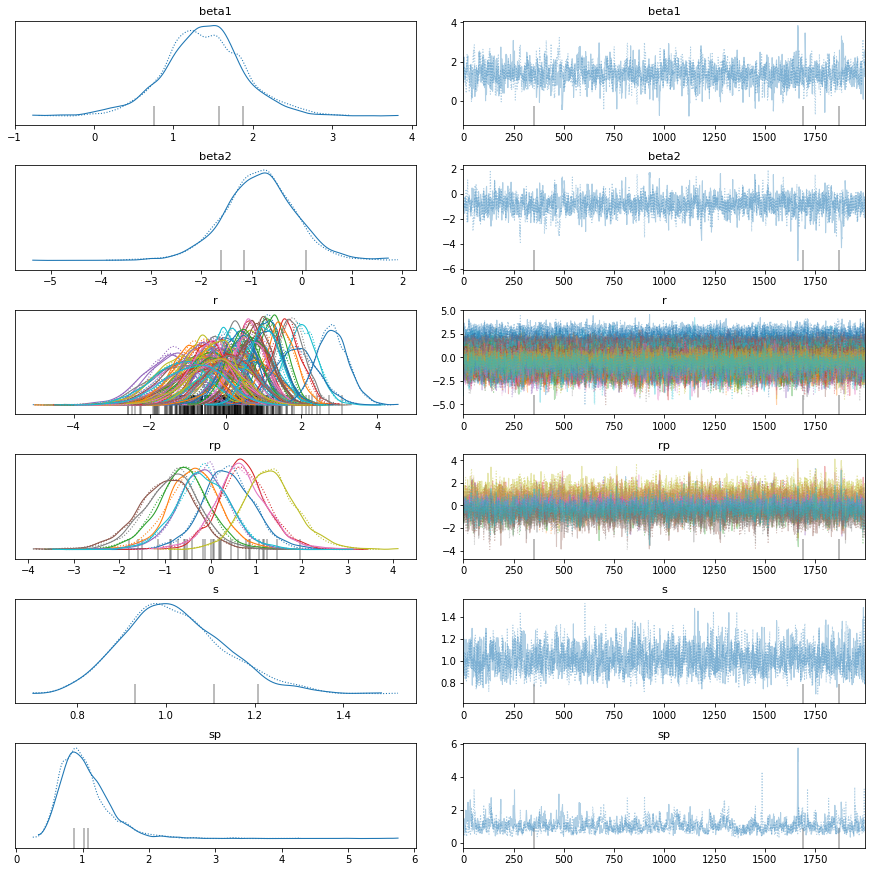

In [51]:
# HMCでサンプリング
with model:
    # 101個目からサンプルを取得するチェインを3つ作る
    trace = pymc3.sample(2000, step=pymc3.HamiltonianMC(), tune=100, random_seed=42)
    
_ = pymc3.traceplot(trace)

pymc3.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]